In [1]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

In [2]:
data=pd.read_csv('./use.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1314)
feature=train_data.drop(['Sel','Unnamed: 0'],axis=1)
label=train_data['Sel']

In [3]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [4]:
def ETR_cv(n_estimators, min_samples_split, max_depth):
    val = cross_val_score(
        ExtraTreesRegressor(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_depth=int(max_depth),
            random_state=1314
        ),
        feature, label, scoring='r2', cv=kfold
    ).mean()
    return val

In [5]:
ETR_opt = BayesianOptimization(
        ETR_cv,
        {'n_estimators': (50, 1000),
        'min_samples_split': (2, 25),
        'max_depth': (2, 15)}
    )

In [6]:
ETR_opt.maximize(n_iter=50)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.1919    | 2.718     | 23.45     | 862.8     |
| 2         | 0.5518    | 7.896     | 11.88     | 757.3     |
| 3         | 0.1889    | 2.849     | 22.98     | 204.2     |
| 4         | 0.5485    | 7.625     | 12.3      | 211.9     |
| 5         | 0.4934    | 6.01      | 20.03     | 381.1     |
| 6         | 0.6719    | 10.38     | 4.718     | 455.6     |
| 7         | 0.3706    | 4.785     | 21.91     | 51.62     |
| 8         | 0.3792    | 4.733     | 10.01     | 422.5     |
| 9         | 0.6156    | 11.87     | 22.17     | 457.8     |
| 10        | 0.6237    | 12.32     | 22.91     | 457.1     |
| 11        | 0.6608    | 13.6      | 15.0      | 448.0     |
| 12        | 0.7392    | 14.98     | 2.0       | 223.7     |
| 13        | 0.1907    | 2.0       | 2.0       | 235.2     |
| 14        | 0.7394    | 14.07     | 2.174     | 212.4     |
| 15    

In [4]:
model = ExtraTreesRegressor(n_estimators=1000,
                            # max_depth=26,
                            # min_samples_split=4,
                            # max_samples=105,
                            max_leaf_nodes=10000,
                            # bootstrap=True,
                            random_state=1314).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.7659241375124074
rmse: 10.381969402903774


In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
test_x = test_data.drop(['Sel','Unnamed: 0'],axis=1)
test_y = test_data['Sel']
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',pow(mean_squared_error(label,model.predict(feature)),0.5))
print('测试集得分为：', r2_score(test_y,model.predict(test_x)),pow(mean_squared_error(test_y,model.predict(test_x)),0.5))

r2: 0.9999868940761705
MAE: 0.07904934921114444
测试集得分为： 0.8138578415209653 9.247548517177359


In [6]:
# 预测1
Y1=model.predict(X=test_data.drop(['Sel','Unnamed: 0'],axis=1))
Y2=test_data['Sel']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [7]:
# 预测2
Y_1=model.predict(X=feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

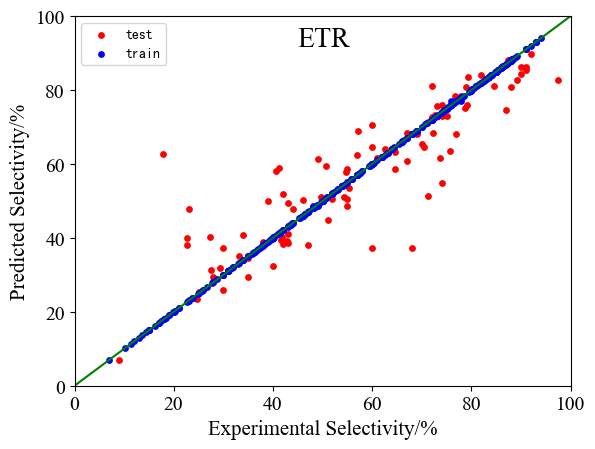

In [8]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,100))
plt.xlabel('Experimental Selectivity/%',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,100))
plt.ylabel('Predicted Selectivity/%',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,100],[0,100],color='g')
plt.text(45,92,'ETR',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()